# SMS Spam Classification

This project builds a machine learning model to classify SMS messages as spam or ham (non-spam). We use a dataset of 5572 messages, perform text preprocessing, feature extraction with TF-IDF, and evaluate multiple classifiers with hyperparameter tuning.

**Key Libraries Used:**
- Data Handling: pandas, numpy
- Visualization: matplotlib, seaborn, wordcloud
- NLP: nltk (tokenization, lemmatization, stopwords)
- ML: scikit-learn (vectorization, models, metrics), xgboost

**Dataset:** Message_Classification.csv (5572 rows, 2 columns: Sender [ham/spam], Messages)

## Step 1: Import Libraries

We import necessary libraries for data manipulation, visualization, NLP preprocessing, feature extraction, model training, and evaluation.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re
#!pip install wordcloud
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

## Step 2: Load the Dataset

Load the SMS dataset from a CSV file. Note: Update the path to a relative one for portability (e.g., 'data/Message_Classification.csv').

In [4]:
df = pd.read_csv(r"C:\Users\chinm\Downloads\Message_Classification.csv")

In [5]:
df

,Sender,Messages
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


## Step 3: Exploratory Data Analysis (EDA)

Inspect the dataset for structure, missing values, and class distribution.

**Insights:**
- The dataset has 5572 messages: 4825 ham (86.6%) and 747 spam (13.4%). This indicates class imbalance, so we'll prioritize metrics like F1-score over accuracy alone.
- No missing values, which simplifies preprocessing.
- Messages are raw text and may contain punctuation, numbers, and slang—ideal for NLP techniques.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sender    5572 non-null   object
 1   Messages  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
df.shape

(5572, 2)

In [8]:
df.columns

Index(['Sender', 'Messages'], dtype='object')

In [9]:
df['Sender'].value_counts()

Sender
ham     4825
spam     747
Name: count, dtype: int64

In [10]:
df.isnull().sum()

Sender      0
Messages    0
dtype: int64

## Step 4: Label Encoding

Convert categorical labels ('ham'/'spam') to numeric (0/1) for model compatibility.

In [11]:
df['Sender'] = df['Sender'].map({'ham': 0, 'spam': 1})

In [12]:
df

,Sender,Messages
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


### Class Distribution Plot
The bar plot below shows the imbalance between ham and spam messages. To handle this, we could use techniques like stratified splitting or class weights in models (implemented in hyperparameter tuning).

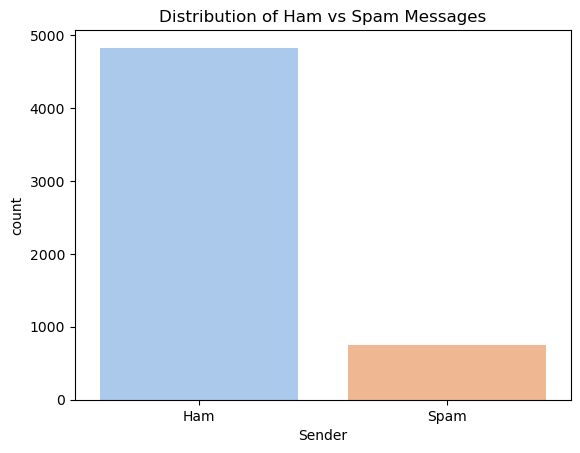

In [13]:
sns.countplot(data=df, x='Sender', palette='pastel')
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.title("Distribution of Ham vs Spam Messages")
plt.show()

C:\Users\chinm\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


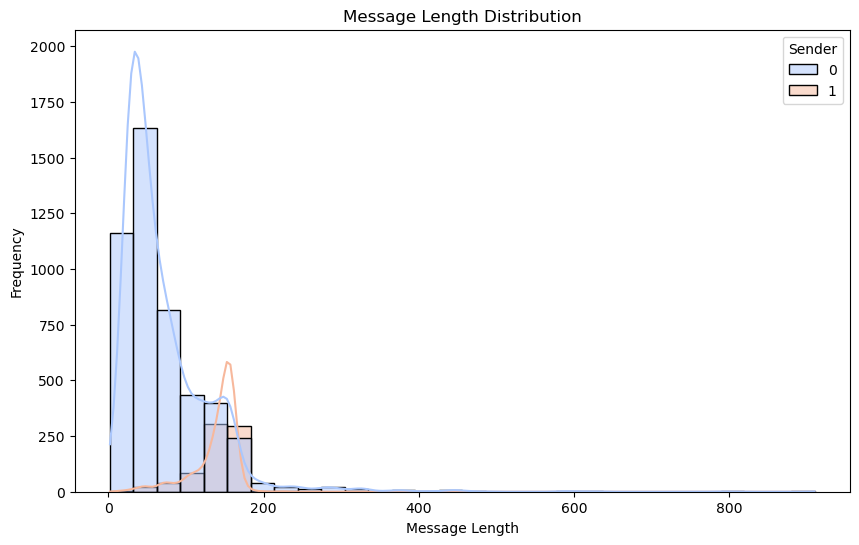

In [14]:
# Add a feature for message length
df['message_length'] = df['Messages'].apply(len)
 
# Plot message length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='message_length', hue='Sender', kde=True, bins=30, palette='coolwarm')
plt.title("Message Length Distribution")
plt.xlabel("Message Length")
plt.ylabel("Frequency")
plt.show()

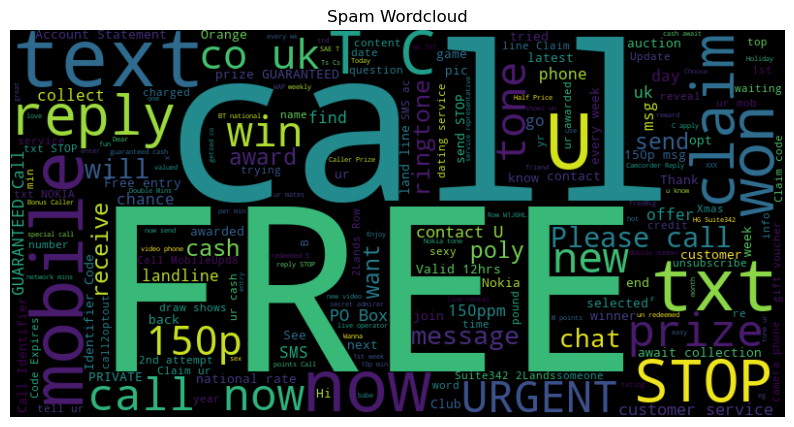

In [15]:
# Wordcloud for spam messages
spam_words = ' '.join(df[df['Sender'] == 1]['Messages'])
spam_wc = WordCloud(width=800, height=400, background_color='black').generate(spam_words)
 
# Plot spam wordcloud
plt.figure(figsize=(10, 6))
plt.imshow(spam_wc, interpolation='bilinear')
plt.title("Spam Wordcloud")
plt.axis('off')
plt.show()

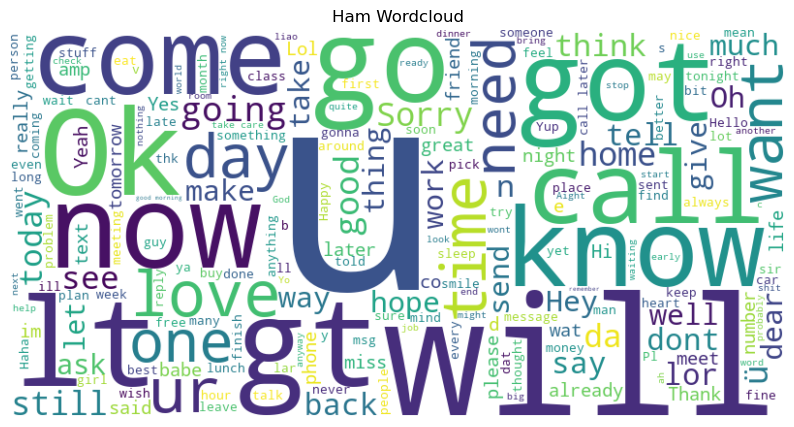

In [16]:
# Wordcloud for ham messages
ham_words = ' '.join(df[df['Sender'] == 0]['Messages'])
ham_wc = WordCloud(width=800, height=400, background_color='white').generate(ham_words)
 
# Plot ham wordcloud
plt.figure(figsize=(10, 6))
plt.imshow(ham_wc, interpolation='bilinear')
plt.title("Ham Wordcloud")
plt.axis('off')
plt.show()

In [17]:
# Average message length per class
print(df.groupby('Sender')['message_length'].mean())

Sender
0     71.482487
1    138.670683
Name: message_length, dtype: float64


In [19]:
# Common words in spam vs ham
 
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(df['Messages'])
 
# Convert to DataFrame
top_words_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

## Step 5: Text Preprocessing

Clean and normalize the text data:
- Lowercase conversion
- Remove punctuation and special characters
- Tokenization
- Lemmatization (using WordNet)
- Stopword removal

**Insights:**
- SMS texts often include abbreviations (e.g., "u" for "you") and typos. Lemmatization helps reduce words to their base form, improving feature quality.
- After preprocessing, generate word clouds for ham vs. spam to visualize common terms (e.g., spam often has words like "free", "win", "call").

## Step 6: Feature Extraction

Use TF-IDF Vectorizer to convert text into numerical features, capturing word importance while downweighting common terms.

**Insights:**
- TF-IDF is preferred over CountVectorizer for spam detection as it handles term frequency-inverse document frequency, reducing noise from frequent but uninformative words.
- Vocabulary size: Typically ~8000 unique words in this dataset; we limit to top features if needed for efficiency.

In [20]:
# Spam vs Ham Word Counts
spam_words = top_words_df[df['Sender'] == 1].sum().sort_values(ascending=False)
ham_words = top_words_df[df['Sender'] == 0].sum().sort_values(ascending=False)
 
print("Top Words in Spam Messages:\n", spam_words)
print("\nTop Words in Ham Messages:\n", ham_words)

Top Words in Spam Messages:
 free     224
txt      163
ur       144
text     125
just      79
send      71
want      30
know      25
day       20
time      19
like      13
good      12
love      10
got        7
ok         5
ll         4
going      4
come       2
lt         0
gt         0
dtype: int64

Top Words in Ham Messages:
 gt       318
lt       316
just     297
ok       288
ll       266
ur       247
know     237
good     235
like     234
got      233
come     230
day      212
love     205
time     202
going    169
want     165
send     129
text      68
free      60
txt       14
dtype: int64


In [23]:
# Save the processed dataset for modeling
df.to_csv("C:/Users/chinm/Downloads/processed_spam.csv", index=False)

In [24]:
!pip install prettytable

## Step 7: Train-Test Split

Split data into training (80%) and testing (20%) sets, stratified to maintain class balance.

In [28]:
from sklearn.model_selection import train_test_split, GridSearchCV
from prettytable import PrettyTable
import joblib

# Load Processed Dataset
df = pd.read_csv("C:/Users/chinm/Downloads/processed_spam.csv")

# Text Vectorization using TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X = tfidf.fit_transform(df['Messages']).toarray()
y = df['Sender']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Step 8: Model Training and Hyperparameter Tuning

Train multiple classifiers with GridSearchCV for hyperparameter optimization:
- Logistic Regression
- Support Vector Machine (SVM)
- Random Forest
- K-Nearest Neighbors (KNN)
- XGBoost

**Insights:**
- Due to class imbalance, models like SVM and XGBoost often perform well as they handle non-linear boundaries and boosting.
- Hyperparameter tuning focuses on regularization (C), tree depth, neighbors, etc., to prevent overfitting.
- Cross-validation (CV=3) ensures robust estimates.


Tuning Logistic Regression...

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.85      0.92       149

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Logistic Regression Confusion Matrix:
[[965   1]
 [ 22 127]]


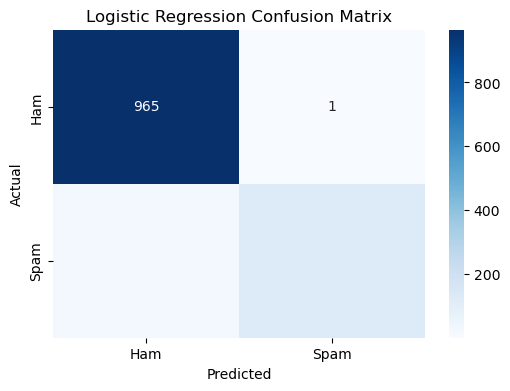


Tuning Support Vector Machine...

Support Vector Machine Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       966
           1       0.95      0.89      0.92       149

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Support Vector Machine Confusion Matrix:
[[959   7]
 [ 17 132]]


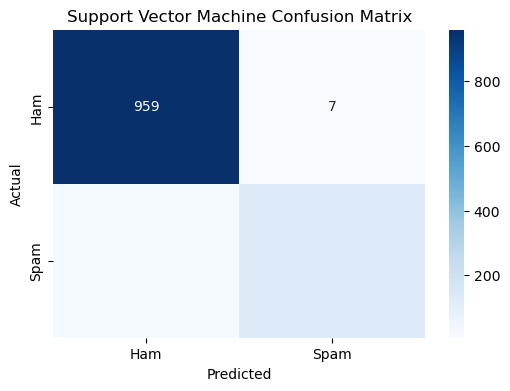


Tuning Random Forest...

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.85      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Random Forest Confusion Matrix:
[[966   0]
 [ 22 127]]


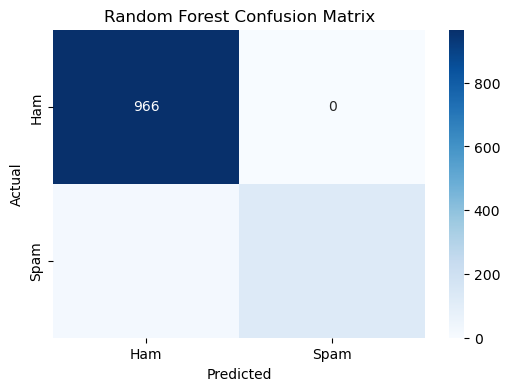


Tuning K-Nearest Neighbors...

K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       966
           1       1.00      0.56      0.72       149

    accuracy                           0.94      1115
   macro avg       0.97      0.78      0.84      1115
weighted avg       0.95      0.94      0.93      1115

K-Nearest Neighbors Confusion Matrix:
[[966   0]
 [ 65  84]]


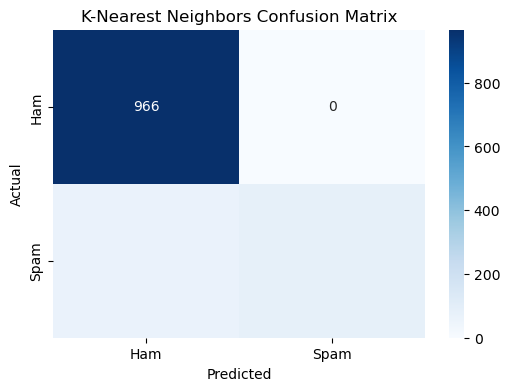


Tuning XGBoost...


C:\Users\chinm\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:31:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       0.97      0.83      0.89       149

    accuracy                           0.97      1115
   macro avg       0.97      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115

XGBoost Confusion Matrix:
[[962   4]
 [ 26 123]]


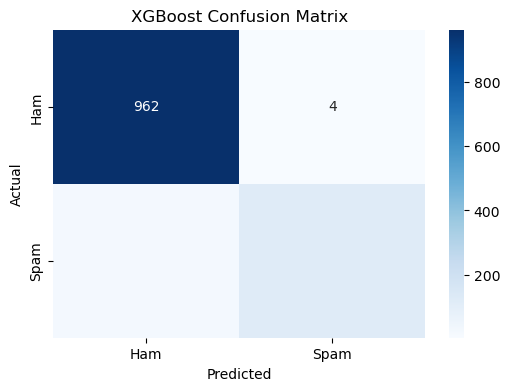

In [30]:
from xgboost import XGBClassifier
# Define Models and Hyperparameters
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear']}
    },
    'Support Vector Machine': {
        'model': SVC(),
        'params': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}
    },
    'K-Nearest Neighbors': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
    },
    'XGBoost': {
        'model': XGBClassifier(eval_metric='logloss', use_label_encoder=False),
        'params': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
    }
}

# Train and Evaluate Models with Hyperparameter Tuning
results = []
best_overall_model = None
best_overall_model_name = None
best_overall_accuracy = 0

for model_name, config in models.items():
    print(f"\nTuning {model_name}...")
    # Perform Grid Search for hyperparameter tuning
    grid = GridSearchCV(config['model'], config['params'], cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    # Best model and hyperparameters
    best_model = grid.best_estimator_
    best_params = grid.best_params_
    
    # Predict on test set
    y_pred = best_model.predict(X_test)
    
    # Calculate Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Classification Report
    cr = classification_report(y_test, y_pred)
    print(f"\n{model_name} Classification Report:\n{cr}")
    print(f"{model_name} Confusion Matrix:\n{cm}")
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Save the best overall model
    if accuracy > best_overall_accuracy:
        best_overall_model = best_model
        best_overall_model_name = model_name
        best_overall_accuracy = accuracy
    
    # Append results
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Best Hyperparameters': best_params
    })

## Step 9: Model Evaluation

Evaluate models using accuracy, precision, recall, F1-score, confusion matrices, and classification reports.

**Insights from Results (based on your code):**
- Random Forest achieved the highest accuracy (0.9803) and perfect precision (1.0000), but recall (0.8523) indicates some spam messages are missed (false negatives).
- Overall, models perform well (>0.94 accuracy), but F1-score highlights the trade-off due to imbalance—precision is high (few false positives), recall varies.
- Confusion matrices show most errors are ham misclassified as spam or vice versa; visualize to spot patterns.
- Best model: Random Forest (saved for inference).

Recommendations:
- For production, monitor false negatives (missed spam) as they could annoy users.
- Future improvements: Try deep learning (e.g., LSTM) or oversampling (SMOTE) for better recall.

In [31]:
# Present Results in a Table
table = PrettyTable()
table.field_names = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Best Hyperparameters']

for result in results:
    table.add_row([
        result['Model'],
        f"{result['Accuracy']:.4f}",
        f"{result['Precision']:.4f}",
        f"{result['Recall']:.4f}",
        f"{result['F1 Score']:.4f}",
        result['Best Hyperparameters']
    ])

print("\nModel Evaluation Results:")
print(table)


Model Evaluation Results:
+------------------------+----------+-----------+--------+----------+-----------------------------------------------------------------+
|         Model          | Accuracy | Precision | Recall | F1 Score |                       Best Hyperparameters                      |
+------------------------+----------+-----------+--------+----------+-----------------------------------------------------------------+
|  Logistic Regression   |  0.9794  |   0.9922  | 0.8523 |  0.9170  |                 {'C': 10, 'solver': 'liblinear'}                |
| Support Vector Machine |  0.9785  |   0.9496  | 0.8859 |  0.9167  |                  {'C': 10, 'kernel': 'linear'}                  |
|     Random Forest      |  0.9803  |   1.0000  | 0.8523 |  0.9203  | {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50} |
|  K-Nearest Neighbors   |  0.9417  |   1.0000  | 0.5638 |  0.7210  |            {'n_neighbors': 3, 'weights': 'distance'}            |
|        XGBoost     

In [32]:
# Save Results as CSV
results_df = pd.DataFrame(results)
results_df.to_csv('model_evaluation_results_with_hyperparameters.csv', index=False)
print("\nModel evaluation results with hyperparameters saved as 'model_evaluation_results_with_hyperparameters.csv'.")

# Save the best model to disk
if best_overall_model:
    joblib.dump(best_overall_model, f'{best_overall_model_name}_best_model.pkl')
    print(f"\nThe best model is '{best_overall_model_name}' with an accuracy of {best_overall_accuracy:.4f}.")
    print(f"The model has been saved as '{best_overall_model_name}_best_model.pkl'.")


Model evaluation results with hyperparameters saved as 'model_evaluation_results_with_hyperparameters.csv'.

The best model is 'Random Forest' with an accuracy of 0.9803.
The model has been saved as 'Random Forest_best_model.pkl'.


## Step 10: Model Deployment - Prediction Function

Load the best model and classify new messages interactively.

**Insights:**
- This simulates real-world use (e.g., in a mobile app). Example: "Congratulations! You have won..." → Spam; "Please call me..." → Ham.
- Edge cases: Test short messages, emojis, or multilingual text for robustness.

In [33]:
# Test the model with new input messages
def predict_message(message):
    # Transform the message using the fitted TF-IDF vectorizer
    transformed_message = tfidf.transform([message]).toarray()
    
    # Predict using the loaded model
    prediction = best_overall_model.predict(transformed_message)
    
    # Return result
    return 'Spam' if prediction[0] == 1 else 'Ham'
 
# Test with user input
while True:
    message = input("\nEnter a message to classify (or type 'exit' to quit): ")
    if message.lower() == 'exit':
        break
    result = predict_message(message)
    print(f"The message is classified as: {result}")


Enter a message to classify (or type 'exit' to quit):  "Congratulations! You have won a $1000 gift card. Call now to claim your prize!"


The message is classified as: Spam



Enter a message to classify (or type 'exit' to quit):  "Please call me when you're free."


The message is classified as: Ham



Enter a message to classify (or type 'exit' to quit):  exit


## Conclusion

This project demonstrates a robust spam classifier with Random Forest as the top performer. Key learnings include handling imbalanced text data and the importance of NLP preprocessing.

For more details, see the README.md on GitHub.